# Dog Breed Classification

## 1. Import my funtions and Libraries

In [25]:
import pandas as pd
from google.colab import drive
import itertools
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import zipfile
import os
import warnings
import shutil
import random
warnings.filterwarnings("ignore")

In [ ]:
# this is my helper funtions uploaded in my github repo.
!wget https://raw.githubusercontent.com/gurokeretcha/gurokeretcha/main/helper_funtions_ML.py

--2021-09-27 08:02:18--  https://raw.githubusercontent.com/gurokeretcha/gurokeretcha/main/helper_funtions_ML.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7520 (7.3K) [text/plain]
Saving to: ‘helper_funtions_ML.py’

helper_funtions_ML. 100%[===================>]   7.34K  --.-KB/s    in 0s      

2021-09-27 08:02:19 (50.6 MB/s) - ‘helper_funtions_ML.py’ saved [7520/7520]



In [ ]:
from helper_funtions_ML import unzip_data, plot_loss_curves, compare_historys, calculate_results, make_confusion_matrix, plot_value_count

In [ ]:
# import kaggle data and unzip : https://www.kaggle.com/c/dog-breed-identification/data
drive.mount('/content/gdrive')
unzip_data("/content/gdrive/MyDrive/Kaggle/dog-breed-identification.zip")

Mounted at /content/gdrive


In [ ]:
labels_df=pd.read_csv('labels.csv')
labels_df.shape

(10222, 2)

## 2. Understand the data

In [ ]:
# note we have 10 222 training images and 10 357 test images
train_images = os.listdir("/content/train/")
test_image = os.listdir("/content/test/")
len(train_images), len(test_image)

(10222, 10357)

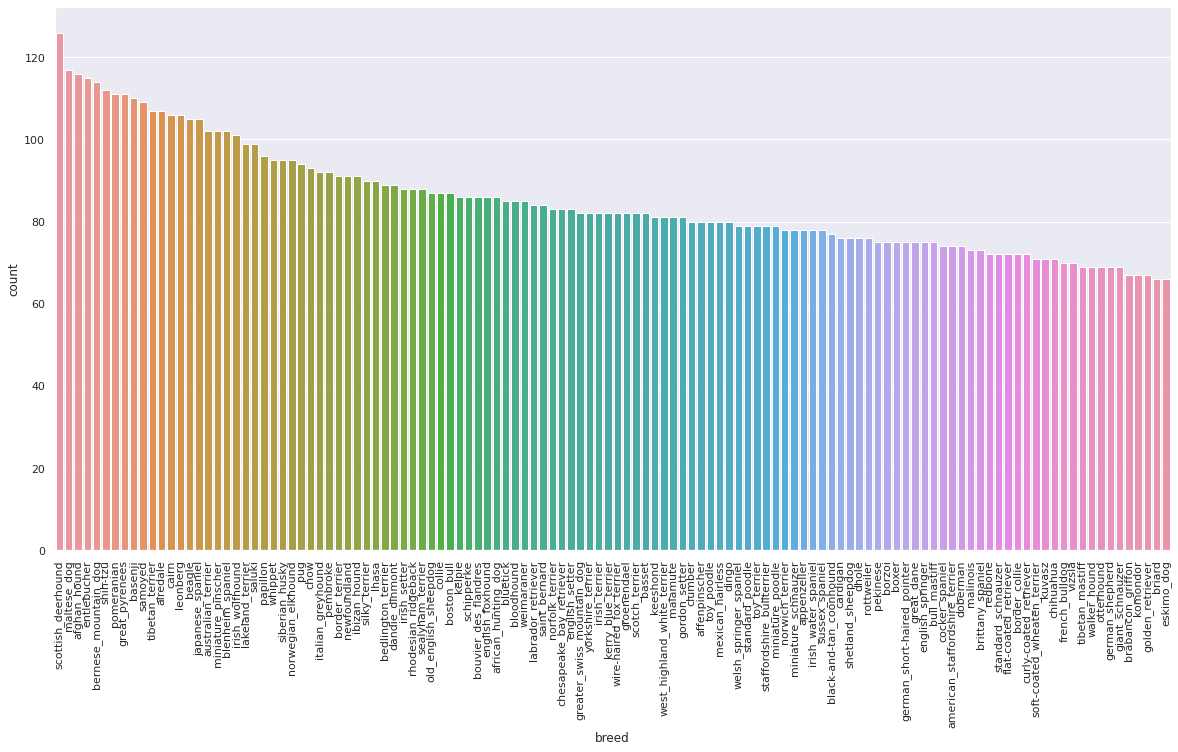

In [ ]:
# lets plot distribution of dog breeds in training data
plot_value_count(labels_df,'breed')

In [ ]:
# how many dog breed? 
target_labels = sorted(labels_df['breed'].unique().tolist())
len(target_labels)

120

## 3. Create Structured form of folders

In [ ]:
# 1.create class folders
parent_folder = "data"
datasets = ["all_data"]
for i in datasets:
  for j in target_labels:
      os.makedirs(parent_folder + "/" + i + "/" + j,  exist_ok=True)

In [ ]:
# all data
for _, name, label in labels_df.itertuples():
  original_path = "/content/train/" + name +".jpg"
  dest_path = "/content/data/all_data/" + label
  shutil.copy(original_path, dest_path)

In [ ]:
# 3. look the data in folders
for dirpath, dirnames, filenames in os.walk("data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'data'.
There are 120 directories and 0 images in 'data/all_data'.
There are 0 directories and 78 images in 'data/all_data/irish_water_spaniel'.
There are 0 directories and 75 images in 'data/all_data/great_dane'.
There are 0 directories and 73 images in 'data/all_data/malinois'.
There are 0 directories and 109 images in 'data/all_data/samoyed'.
There are 0 directories and 81 images in 'data/all_data/gordon_setter'.
There are 0 directories and 80 images in 'data/all_data/affenpinscher'.
There are 0 directories and 80 images in 'data/all_data/toy_poodle'.
There are 0 directories and 85 images in 'data/all_data/weimaraner'.
There are 0 directories and 93 images in 'data/all_data/chow'.
There are 0 directories and 96 images in 'data/all_data/papillon'.
There are 0 directories and 75 images in 'data/all_data/borzoi'.
There are 0 directories and 81 images in 'data/all_data/malamute'.
There are 0 directories and 82 images in 'data/all_data/groenendael'

## 4. Visualize Random Images

In [ ]:
all_data_dir = "/content/data/all_data/"

def view_25_random_image(target_dir, target_classes):
  plt.figure(figsize=(18, 12))
  random_images = []
  for i, target_class in enumerate(target_classes):
    # setup the target directory
    target_folder = target_dir + target_class

    # get the random image path
    random_image = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    #print(target_folder + "/" + random_image[0])
    #print(random_image)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"{target_class}")
    plt.axis("off");
    random_images.append(img)
    #print(f"image shape: {img.shape}")
  return random_images

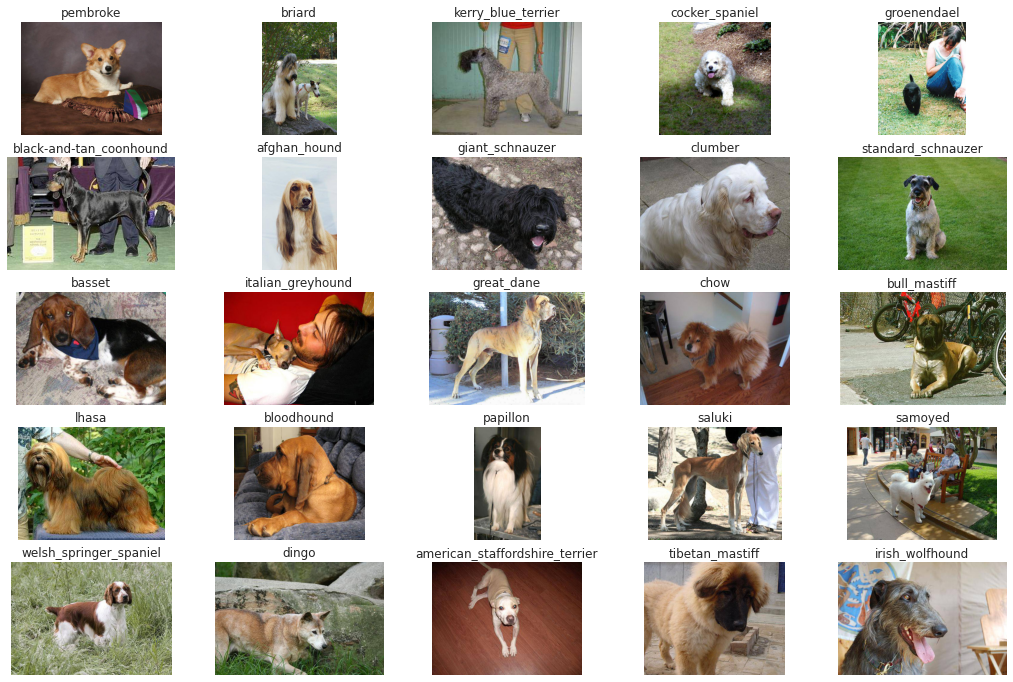

In [ ]:
random_images = view_25_random_image(target_dir=all_data_dir,
                                target_classes = random.sample(target_labels,25))

## 5. Visualize Image Sizes

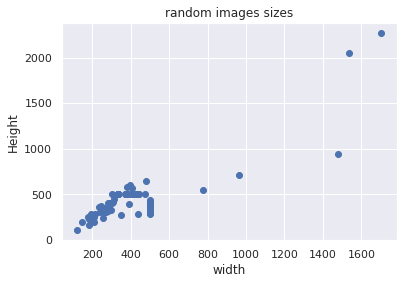

In [ ]:
random_images_shape = []
target_classes =random.sample(target_labels,110) 
for i, target_class in enumerate(target_classes):
  # setup the target directory
  target_folder = all_data_dir + target_class

  # get the random image path
  random_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  random_images_shape.append(img.shape[0:2])
len(random_images_shape)
plt.scatter(pd.DataFrame(random_images_shape)[0], pd.DataFrame(random_images_shape)[1])
plt.xlabel("width")
plt.ylabel("Height")
plt.title("random images sizes")
#plt.grid()
plt.show()

note: we will use 331 331 image size because later in pre-trained model NASNetLarge requres this image size

## 6. Get The  Data 

In [26]:
tf.random.set_seed(42)
IMG_SIZE  = (331,331)
IMG_SHAPE = IMG_SIZE +(3,)
BATCH_SIZE = 32
data_all = tf.keras.preprocessing.image_dataset_from_directory(all_data_dir,
                                                                                                      label_mode = "categorical",
                                                                                                      image_size=IMG_SIZE,
                                                                                                      batch_size=BATCH_SIZE,
                                                               )
print(f"all_data batches: {len(data_all)}")

Found 10222 files belonging to 120 classes.
all_data batches: 320


In [27]:
images_all = []
labels_all = []
for img, label in data_all.unbatch():
  images_all.append(tf.cast(img,dtype=tf.uint8)) # not too loose to much ram
  labels_all.append(label)
# all data images and labels
len(images_all), len(labels_all)

(10222, 10222)

In [28]:
images_all = tf.convert_to_tensor(images_all)
labels_all = tf.convert_to_tensor(labels_all)
# first image and label shapes
images_all[0].shape, labels_all[0].shape

(TensorShape([331, 331, 3]), TensorShape([120]))

In [29]:
data_all_test = tf.keras.preprocessing.image_dataset_from_directory('test/', image_size=IMG_SIZE, label_mode=None, batch_size=BATCH_SIZE,shuffle=False)
test_images = []
for test_image in data_all_test.unbatch():
  test_images.append(tf.cast(test_image,dtype=tf.uint8)) # dtype is uint because to reduce RAM usage
test_images = tf.convert_to_tensor(test_images)

Found 10357 files belonging to 1 classes.


In [30]:
test_images[0].shape

TensorShape([331, 331, 3])

## 7. Set up Training

### Data Augmentation

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_layer = tf.keras.models.Sequential([
                                                preprocessing.RandomFlip("horizontal"),
                                                preprocessing.RandomRotation(0.1),
                                                preprocessing.RandomHeight(0.1),
                                                preprocessing.RandomWidth(0.1),
                                                preprocessing.RandomZoom(0.1),
                                                #preprocessing.Rescaling(1/255.0),
])

### Model callbacks

In [59]:
import datetime
# 1. ModelCheckpoint Callback (save model weigts)
checkpoint_path = "dog_breed_model_checkpoints"
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                                                                    save_weights_only = True,
                                                                                                    monitor="val_accuracy",
                                                                                                    save_best_only=True)

# 2. EarlyStopping Callback (stop training in val accuracy not improves)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=4,
                                                  restore_best_weights=True)

#3. ReduceLROnPlateau Callback (Creating learning rate)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-5)

#4. LearningRateScheduler (in orrder to find best learning rate value)
learning_rate_scheculer = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/5)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

#5. tensorboard - callback (to compare models in tensorboard later)
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## 8. Training Models

### 8.1 Model_0 - Baseline

In [33]:
baseline_model = tf.keras.applications.EfficientNetB0(include_top=False)
# trainable freeze
baseline_model.trainable = False
inputs = tf.keras.Input(shape = IMG_SIZE+(3,), name = "input_layer")
#x = data_augmentation_layer(inputs)
x = baseline_model(inputs, training=False) # weights whhich need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pool_layer")(x)
x = layers.Dense(len(data_all.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)
model_0 = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [34]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 331, 331, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_layer (G (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
_________________________________________________________________
activation (Activation)      (None, 120)               0         
Total params: 4,203,291
Trainable params: 153,720
Non-trainable params: 4,049,571
_________________________________________________________________


In [35]:
# Check the dtype_policy attributes of layers in our model
for layer in model_0.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers
print("**********************************************************")
for layer in model_0.layers[1].layers[:5]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pool_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
activation True float32 <Policy "float32">
**********************************************************
input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">


In [36]:
train_size = int(0.7 * len(data_all))
train_size

224

In [39]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss="categorical_crossentropy",
                              metrics = ["accuracy"])
history_0 = model_0.fit(data_all.take(train_size),
                                      epochs=100,
                                      validation_data = data_all.skip(train_size),
                                      callbacks = [
                                                          #checkpoint_callbacks, 
                                                          early_stopping,
                                                          reduce_lr,
                                                          #learning_rate_scheculer,
                                                          #create_tensorboard_callback("transfer_learning","experiment_0")
                                                          ])

Epoch 1/100
224/224 [==============================] - 47s 183ms/step - loss: 0.0912 - accuracy: 0.9888 - val_loss: 0.5174 - val_accuracy: 0.8363
Epoch 2/100
224/224 [==============================] - 40s 178ms/step - loss: 0.0697 - accuracy: 0.9932 - val_loss: 0.5247 - val_accuracy: 0.8353
Epoch 3/100
224/224 [==============================] - 40s 178ms/step - loss: 0.0550 - accuracy: 0.9967 - val_loss: 0.5284 - val_accuracy: 0.8356

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
224/224 [==============================] - 41s 183ms/step - loss: 0.0435 - accuracy: 0.9976 - val_loss: 0.5134 - val_accuracy: 0.8389
Epoch 5/100
224/224 [==============================] - 41s 182ms/step - loss: 0.0402 - accuracy: 0.9979 - val_loss: 0.5106 - val_accuracy: 0.8415
Epoch 6/100
224/224 [==============================] - 42s 185ms/step - loss: 0.0382 - accuracy: 0.9982 - val_loss: 0.5117 - val_accuracy: 0.8415
Epoch 7/100
224/224 [=====================

In [40]:
#evaluation
evaluation_0 = model_0.evaluate(data_all.skip(train_size))
evaluation_0

96/96 [==============================] - 19s 95ms/step - loss: 0.5103 - accuracy: 0.8438


[0.5103145241737366, 0.8438113927841187]

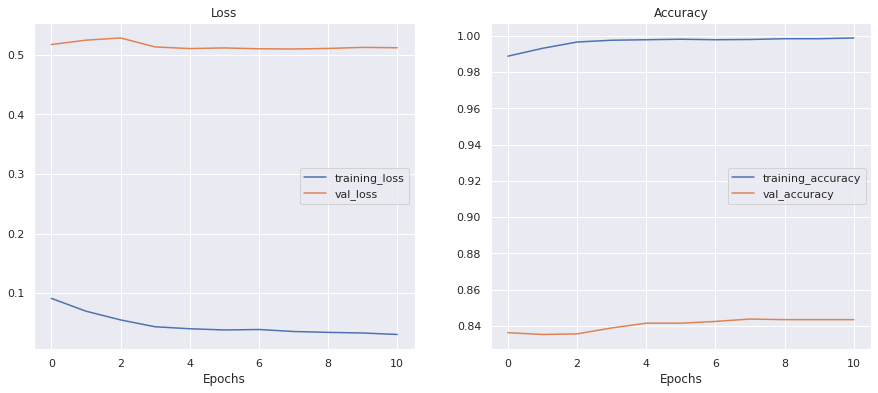

In [41]:
plot_loss_curves(history_0)

note:

1. evaluation score is: 0.8438
2. the model is note generalized well, it learns too well on train data, but not the same way on unseen data.
3. our goal is to imporve evaluation score and generalize the model performance as well

### Model_1 - Combination of different pre-trained models
we can use different pre prained models from the [keras website](https://keras.io/api/applications/) such as : 
* NASNetLarge - 0.825
* InceptionResNetV2 - 0.803
* Xception - 0.790
* EfficientNetB7 - 0.780



In [42]:
from tensorflow.keras import layers

In [43]:
def get_feature_map(pretrained_model , m_preprocessor, data):
  inputs = tf.keras.Input(shape = IMG_SHAPE, name = "input_layer")
  #x = layers.experimental.preprocessing.Rescaling(1/255.0)(inputs)
  preprocessor = layers.Lambda(m_preprocessor)(inputs)
  base_model = pretrained_model (weights="imagenet", include_top=False, input_shape = IMG_SHAPE)(preprocessor)
  outputs = layers.GlobalAveragePooling2D(name="global_average_pool_layer")(base_model)
  feature_extractor = tf.keras.Model(inputs,outputs)
  # feature map
  feature_map = feature_extractor.predict(data,verbose=1)
  print(feature_map.shape)
  return feature_map

In [44]:
def concat_features(data_ext):
  #1. NASNetLarge
  feat1 = get_feature_map (
      pretrained_model = tf.keras.applications.NASNetLarge,
      m_preprocessor = tf.keras.applications.nasnet.preprocess_input,
      data = data_ext
  )

  #2. InceptionResNetV2
  feat2 = get_feature_map (
      pretrained_model = tf.keras.applications.InceptionResNetV2,
      m_preprocessor = tf.keras.applications.inception_resnet_v2.preprocess_input,
      data = data_ext
  )
  #3. Xception
  feat3 = get_feature_map(
      pretrained_model = tf.keras.applications.Xception,
      m_preprocessor = tf.keras.applications.xception.preprocess_input,
      data = data_ext
  )
    #4. EfficientNetB7
  feat4 = get_feature_map(
      pretrained_model = tf.keras.applications.EfficientNetB7,
      m_preprocessor = tf.keras.applications.efficientnet.preprocess_input,
      data = data_ext
  )
  final_features = np.concatenate([feat1, feat2,feat3,feat4], axis=-1)
  print('Feature Map Final: ', final_features.shape)
  return final_features

In [45]:
images_all_features = concat_features(images_all)

320/320 [==============================] - 174s 525ms/step
(10222, 4032)
320/320 [==============================] - 68s 200ms/step
(10222, 1536)
320/320 [==============================] - 48s 147ms/step
(10222, 2048)
320/320 [==============================] - 147s 443ms/step
(10222, 2560)
Feature Map Final:  (10222, 10176)


In [60]:
split = int(len(images_all_features)  * 0.8) 
train_images_test =images_all_features[0:split]
train_labels_test = labels_all[0:split]
valid_images_test = images_all_features[ split:]
valid_labels_test =  labels_all[split:]
len(train_images_test), len(train_labels_test), len(valid_images_test), len(valid_labels_test)

(8177, 8177, 2045, 2045)

In [68]:
model_final = tf.keras.models.Sequential([
                                    layers.Dropout(0.85, input_shape = (images_all_features.shape[1],) ),
                                    layers.Dense(len(data_all.class_names)),
                                    layers.Activation("softmax", dtype=tf.float32)
])
model_final.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss="categorical_crossentropy",
                              metrics = ["accuracy"])

history_final = model_final.fit(train_images_test,train_labels_test,
                                epochs=100,
                                batch_size = BATCH_SIZE,
                                validation_data = (valid_images_test,valid_labels_test),
                                #validation_split = 0.3,
                                callbacks = [
                                                    #checkpoint_callbacks, 
                                                    early_stopping,
                                                    reduce_lr
                                                    #learning_rate_scheculer,
                                                    #create_tensorboard_callback("transfer_learning","experiment_0")
                                                    ]
                                )

Epoch 1/100
256/256 [==============================] - 1s 4ms/step - loss: 0.8409 - accuracy: 0.8169 - val_loss: 0.1988 - val_accuracy: 0.9379
Epoch 2/100
256/256 [==============================] - 1s 3ms/step - loss: 0.1901 - accuracy: 0.9426 - val_loss: 0.1921 - val_accuracy: 0.9403
Epoch 3/100
256/256 [==============================] - 1s 3ms/step - loss: 0.1662 - accuracy: 0.9505 - val_loss: 0.2161 - val_accuracy: 0.9364
Epoch 4/100
256/256 [==============================] - 1s 3ms/step - loss: 0.1421 - accuracy: 0.9539 - val_loss: 0.2080 - val_accuracy: 0.9399

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
256/256 [==============================] - 1s 3ms/step - loss: 0.1041 - accuracy: 0.9675 - val_loss: 0.1990 - val_accuracy: 0.9413
Epoch 6/100
256/256 [==============================] - 1s 3ms/step - loss: 0.1035 - accuracy: 0.9664 - val_loss: 0.2028 - val_accuracy: 0.9418
Epoch 7/100
256/256 [==============================] - 1s 3m

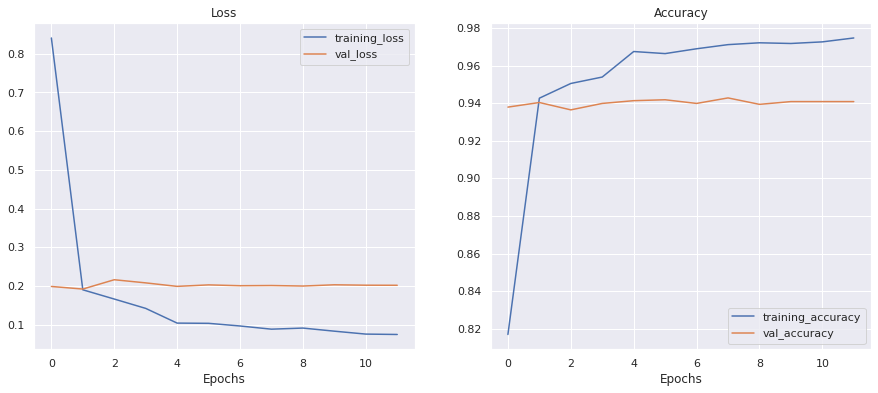

In [69]:
plot_loss_curves(history_final)

In [118]:
# save model
model_final.save("my model")

INFO:tensorflow:Assets written to: my model/assets


## 9. Evaluation Model Performance

In [70]:
pred_probs = model_final.predict(valid_images_test, verbose=1) # set verbosity to see how long it will take
pred_probs.shape

64/64 [==============================] - 0s 1ms/step


(2045, 120)

In [71]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 81,  18,  78,   7, 104,  52, 111, 107,  13,  32])

In [72]:
y_labels = tf.argmax(valid_labels_test,axis=1)
y_labels[0:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 81,  18,  78,   7, 104,  52, 111, 107,  13,  32])>

In [73]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9427872860635697

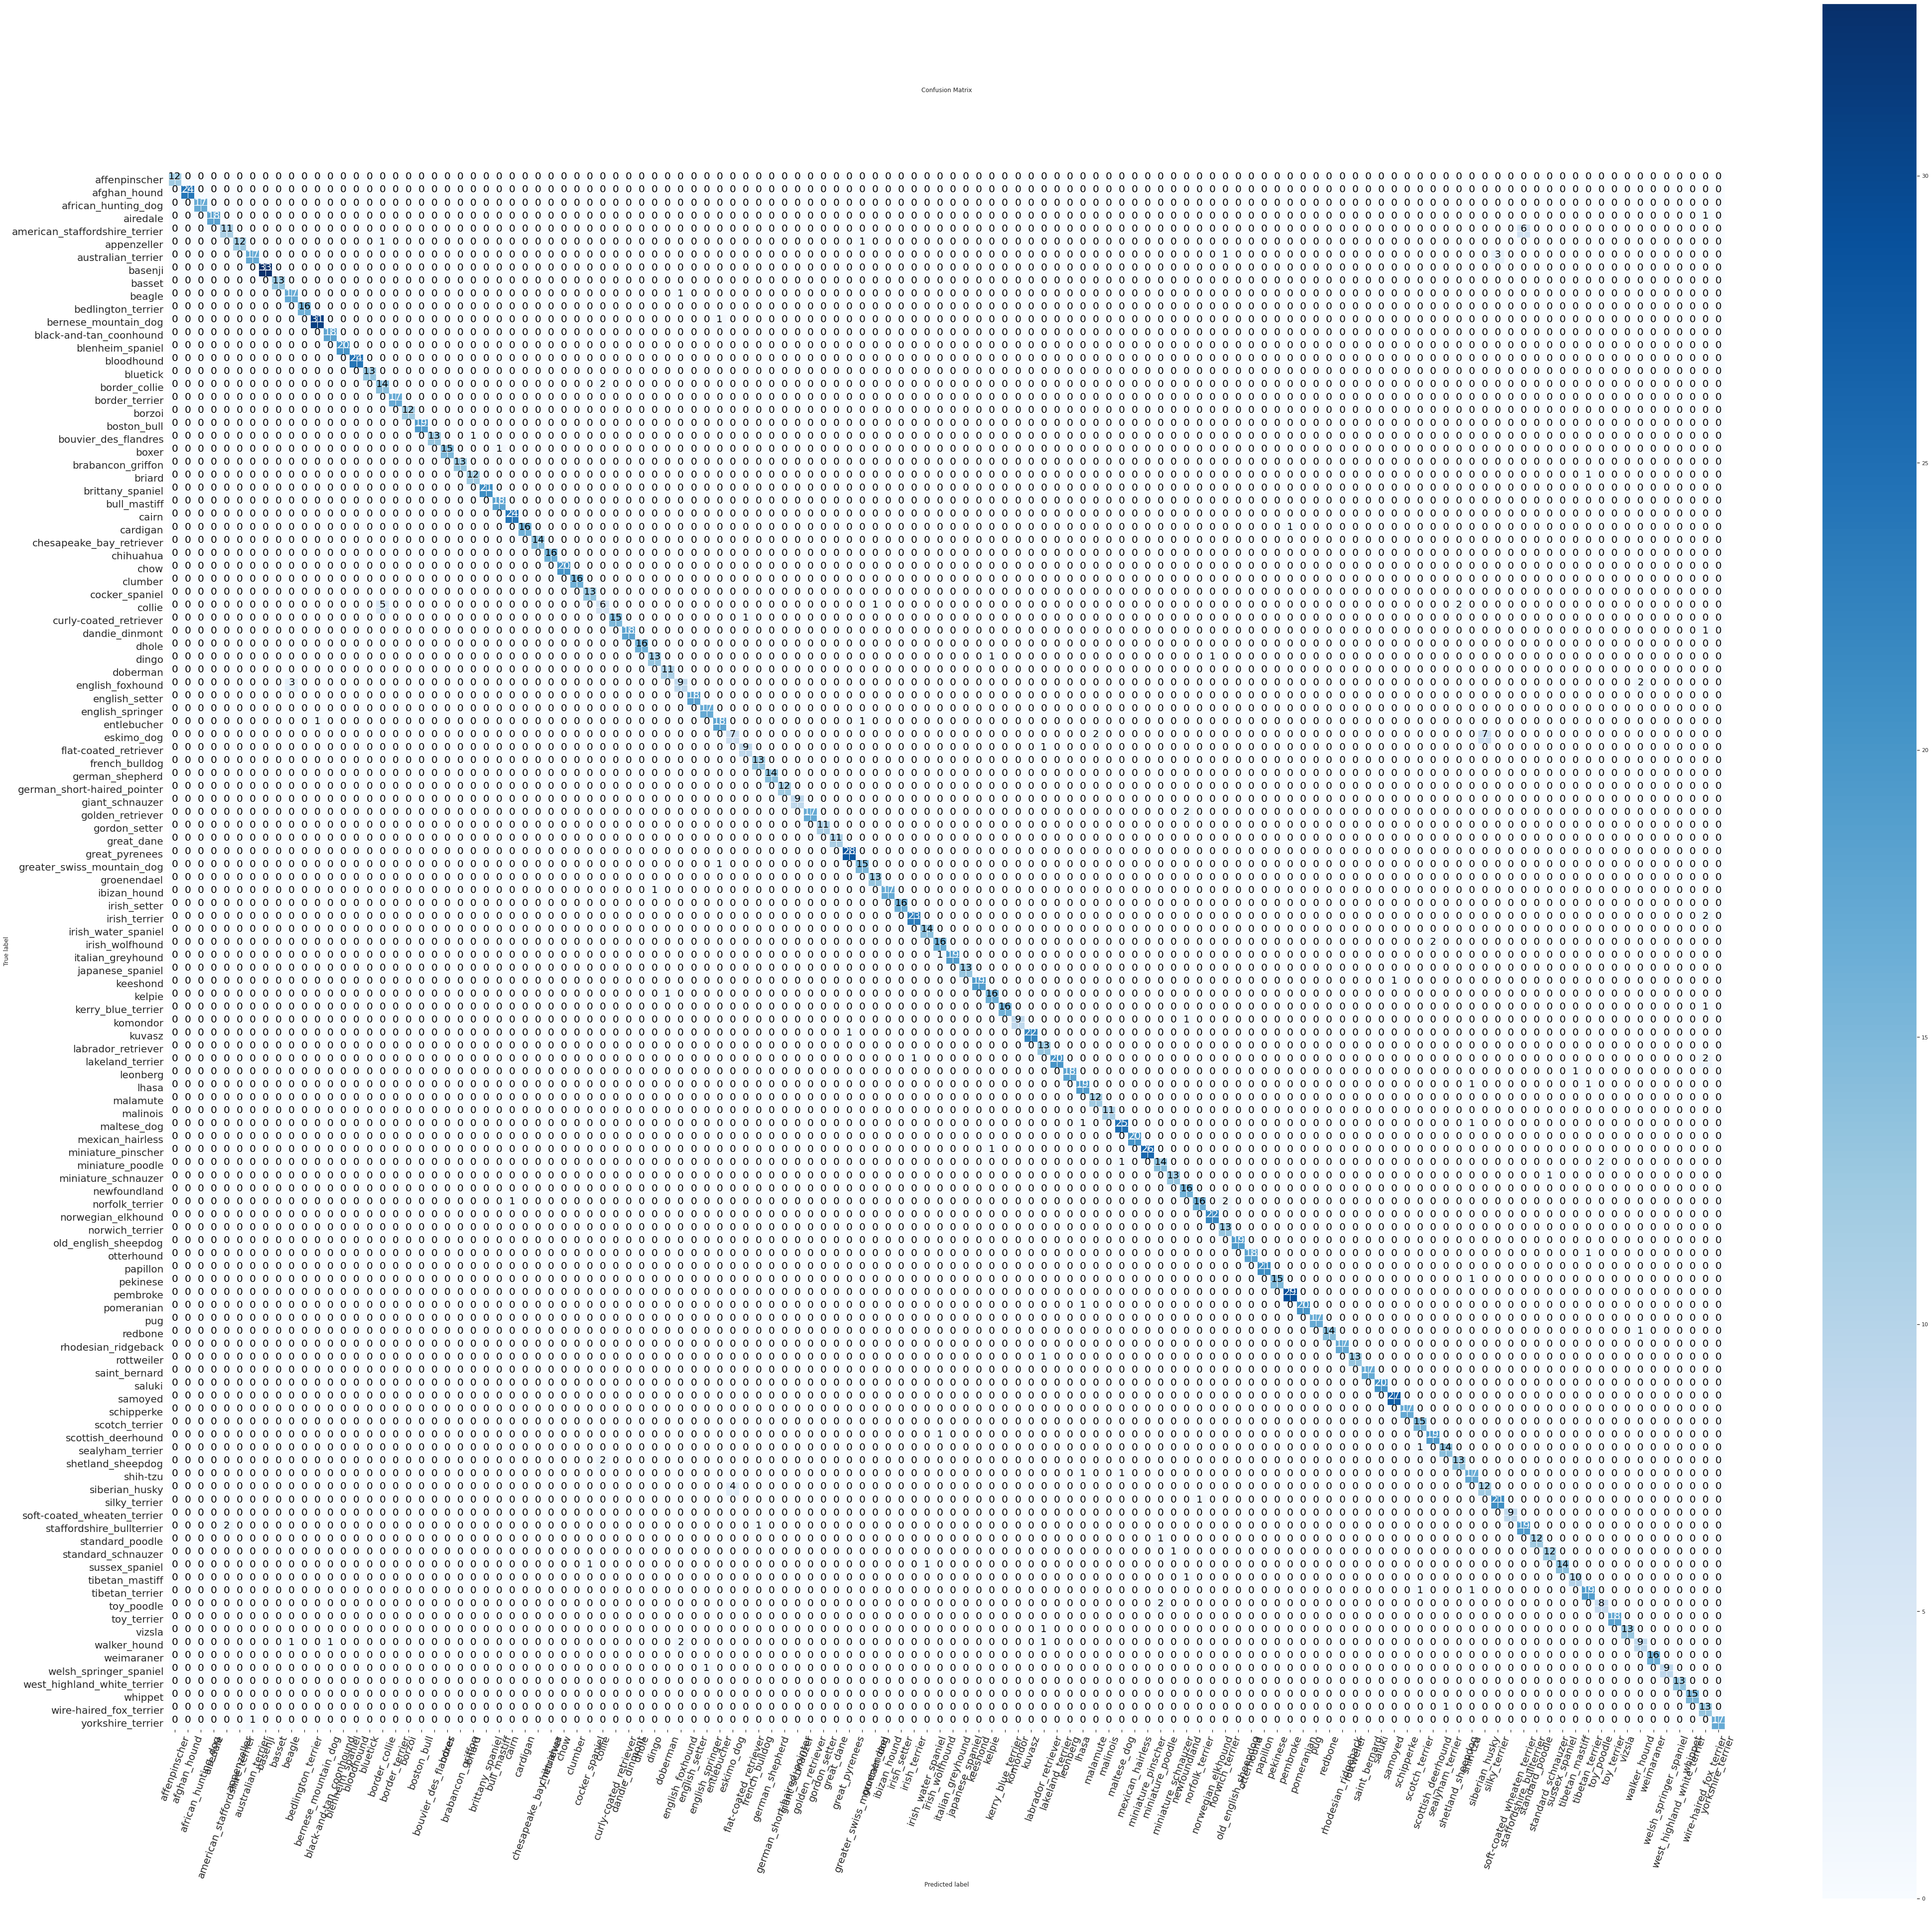

In [77]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=data_all.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [78]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[data_all.class_names[int(k)]] = v["f1-score"]

In [80]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

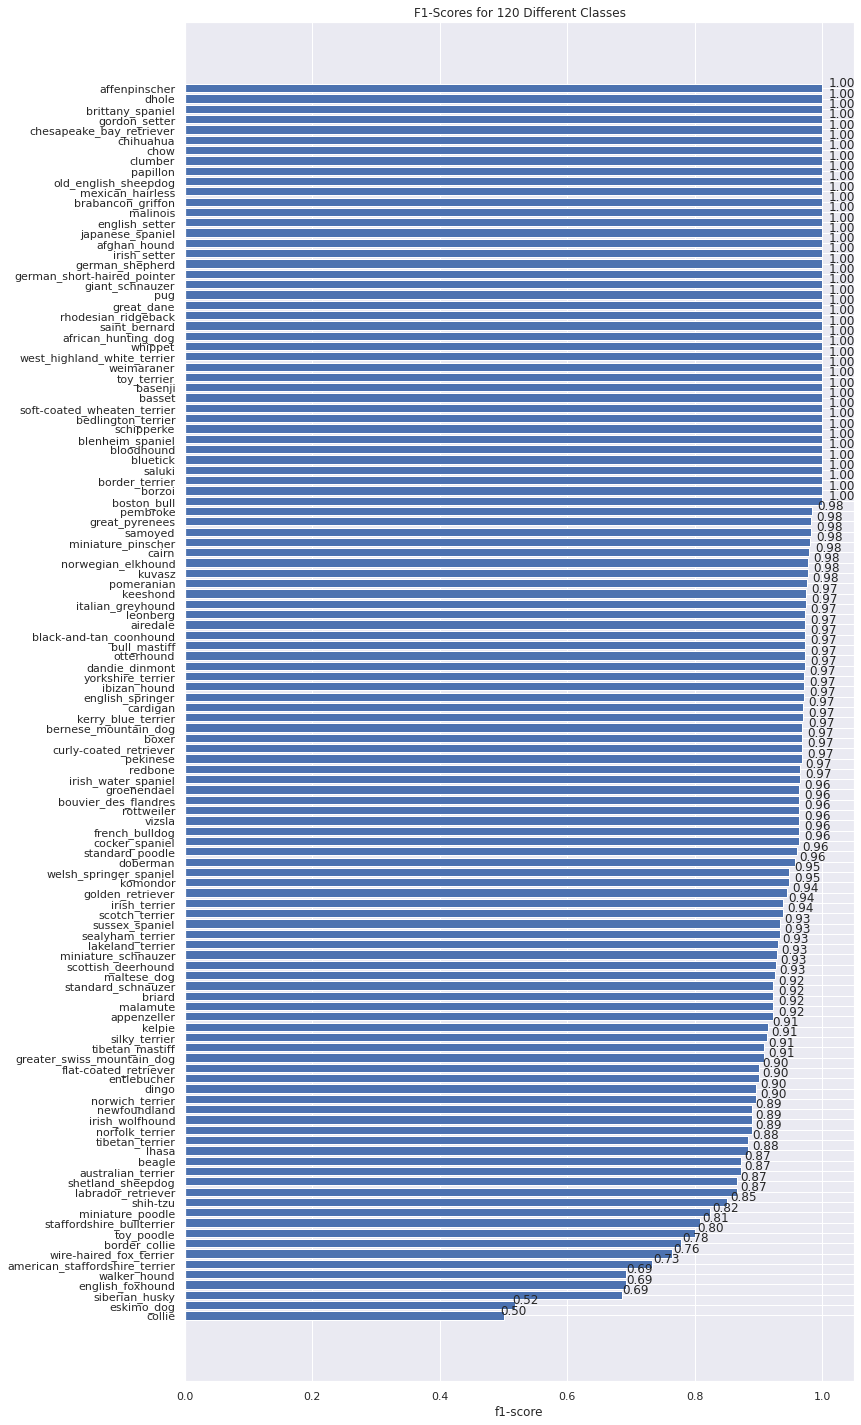

In [82]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 120 Different Classes")
ax.invert_yaxis(); # reverse the order

def labeling(rects): 

  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
labeling(scores)

## 10. Train on test set and make prediction

In [83]:
test_images_features = concat_features(test_images)

324/324 [==============================] - 177s 527ms/step
(10357, 4032)
324/324 [==============================] - 68s 201ms/step
(10357, 1536)
324/324 [==============================] - 48s 148ms/step
(10357, 2048)
324/324 [==============================] - 149s 444ms/step
(10357, 2560)
Feature Map Final:  (10357, 10176)


In [84]:
pred_prob = model_final.predict(test_images_features)
pred_prob.shape

(10357, 120)

In [91]:
max(pred_prob[0])

0.99803966

In [86]:
## submision file
submition_dataFrame = pd.read_csv("/content/sample_submission.csv")
submition_dataFrame.shape

(10357, 121)

In [87]:
submition_dataFrame.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [88]:
submition_dataFrame[data_all.class_names] = pred_prob
submition_dataFrame.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,3.127900e-08,3.959984e-08,3.810437e-08,6.401673e-09,3.362678e-09,1.021585e-08,1.076689e-08,1.100206e-08,7.598318e-09,2.910783e-09,5.936433e-09,6.880413e-08,4.048838e-08,7.007210e-06,3.006994e-08,9.161844e-09,9.354117e-09,3.201885e-09,1.715966e-08,3.392320e-08,4.403472e-08,5.836369e-08,4.793199e-08,2.691957e-09,3.000587e-09,3.708032e-08,1.118721e-09,5.929055e-09,8.300719e-09,1.103832e-08,1.417378e-08,4.175068e-08,1.484351e-08,4.831575e-08,8.785586e-09,3.319511e-09,2.297272e-08,1.537572e-08,4.636627e-08,...,1.036683e-08,3.203229e-09,9.372261e-09,9.059510e-09,3.576048e-07,1.949236e-03,3.083497e-08,5.355960e-07,2.338996e-08,8.178515e-09,4.142783e-08,9.992069e-09,2.747304e-08,2.617589e-08,3.900479e-08,1.443956e-07,4.389927e-09,7.866747e-09,5.311754e-08,6.560779e-08,6.078980e-07,1.774057e-08,2.550308e-09,1.185917e-09,1.169937e-08,2.948833e-08,2.193769e-09,2.823346e-07,4.207757e-08,1.595600e-07,2.548534e-08,1.742902e-08,8.685700e-09,4.041953e-09,1.290569e-08,1.180960e-09,3.933794e-08,2.320529e-08,3.151651e-08,7.188540e-09
1,00102ee9d8eb90812350685311fe5890,9.583330e-08,6.533568e-08,1.663958e-08,3.139262e-08,4.037125e-08,4.675991e-07,9.544598e-09,7.646532e-08,2.500671e-08,2.199322e-08,6.339089e-08,4.470932e-08,6.128489e-08,9.903884e-08,1.369399e-07,2.326374e-08,1.254689e-07,3.154772e-08,2.071276e-08,2.650066e-08,5.219550e-07,5.187134e-08,1.951172e-08,2.016457e-08,6.889707e-09,2.733146e-08,1.471733e-08,9.031526e-09,3.272033e-08,5.834910e-08,7.863154e-07,1.791477e-08,2.395469e-08,2.774684e-07,1.711122e-08,8.265220e-09,1.481741e-07,7.331527e-08,5.817922e-07,...,5.619039e-07,1.949979e-07,2.869206e-08,1.331525e-09,1.667918e-07,4.422402e-08,3.234723e-07,3.286511e-05,8.497310e-08,1.424297e-07,8.529754e-08,4.784886e-08,1.031921e-08,2.472052e-08,9.998916e-01,2.247129e-06,1.368301e-08,2.077119e-08,1.625766e-08,6.438007e-08,7.638326e-08,2.761339e-06,6.890183e-08,6.490159e-08,9.002637e-08,1.553781e-07,1.951623e-08,8.108622e-08,2.243176e-07,9.746731e-08,1.423960e-07,2.510478e-08,1.953414e-08,8.903559e-08,1.344486e-07,1.703775e-08,4.847103e-07,8.254165e-08,2.070253e-08,1.503563e-07
2,0012a730dfa437f5f3613fb75efcd4ce,5.440875e-09,4.585992e-07,1.904549e-07,3.282852e-08,2.186883e-09,2.518722e-07,7.371241e-09,1.587063e-08,1.040131e-07,1.957380e-09,3.385233e-08,4.675414e-08,1.998665e-08,1.086507e-07,9.702967e-08,2.738269e-07,1.309884e-08,1.816733e-08,5.134265e-07,6.182230e-09,1.898617e-08,9.239020e-08,2.746836e-08,5.748938e-08,2.199293e-06,1.777757e-09,1.023977e-08,9.371414e-09,1.053977e-07,6.146498e-09,1.771476e-08,3.781028e-07,4.821337e-07,9.665834e-09,1.557520e-09,6.676063e-08,1.462893e-08,1.975033e-08,4.547108e-08,...,1.255458e-08,6.610576e-09,3.142027e-08,1.473876e-07,9.716111e-09,3.218668e-08,8.994301e-09,2.428133e-08,1.405046e-08,2.352848e-08,3.886159e-08,1.449465e-08,3.718809e-08,2.033381e-06,7.206257e-09,7.482339e-09,4.552

In [89]:
submition_dataFrame.iloc[:,1:].idxmax(axis=1).head(10)

0      japanese_spaniel
1               samoyed
2        english_setter
3                   pug
4                 lhasa
5       standard_poodle
6    australian_terrier
7               samoyed
8       irish_wolfhound
9        sussex_spaniel
dtype: object

In [90]:
submition_dataFrame.to_csv("Submision_test_dataset.csv",index=False)

## 11. Custom Image prediction: My GF's dog prediction

In [103]:
duche = "/content/duche/duche4.jpg"
img = tf.keras.preprocessing.image.load_img(duche, target_size=IMG_SHAPE) 
img_g = np.expand_dims(img, axis=0)

In [104]:
test_features = concat_features(img_g)
predg = model_final.predict(test_features)

1/1 [==============================] - 6s 6s/step
(1, 4032)
1/1 [==============================] - 3s 3s/step
(1, 1536)
1/1 [==============================] - 1s 784ms/step
(1, 2048)
1/1 [==============================] - 5s 5s/step
(1, 2560)
Feature Map Final:  (1, 10176)


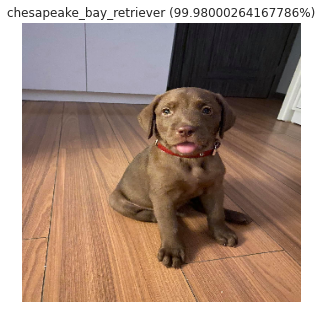

In [117]:
plt.figure(figsize=(5,8))
plt.imshow(img)
plt.title(f"{data_all.class_names[np.argmax(predg[0])]} ({round(np.max(predg[0]),4) * 100}%)")
plt.grid()
plt.axis(False)
plt.show()

In [107]:
print(f"Predicted label: {[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

Predicted label: [28]
Probability of prediction): 100 %
